# import package

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

np.random.seed(1)


In [3]:
# 設變數
OUTLIER_METHOD = "iqr"          # "iqr" / "zscore"
OUTLIER_THRESHOLD = 3.0
OUTLIER_TARGET = "negative"     # "negative" / "positive" / "all"
BALANCE = "downsampled"         # "downsampled" / "smote"
FOLD_METHOD = "StratifiedKFold" # "StratifiedKFold" / "KFold"
FOLD_N_SPLIT = 5
# Encoder = target encoding     # target encoding / frequency encoding

# Explore data

In [4]:
# train = pd.read_csv("train.csv", index_col=0)
# test = pd.read_csv("test.csv", index_col=0)
train = pd.read_csv('/content/drive/MyDrive/111_2/eHealth/hw5/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/111_2/eHealth/hw5/test.csv', index_col=0)

In [5]:
train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


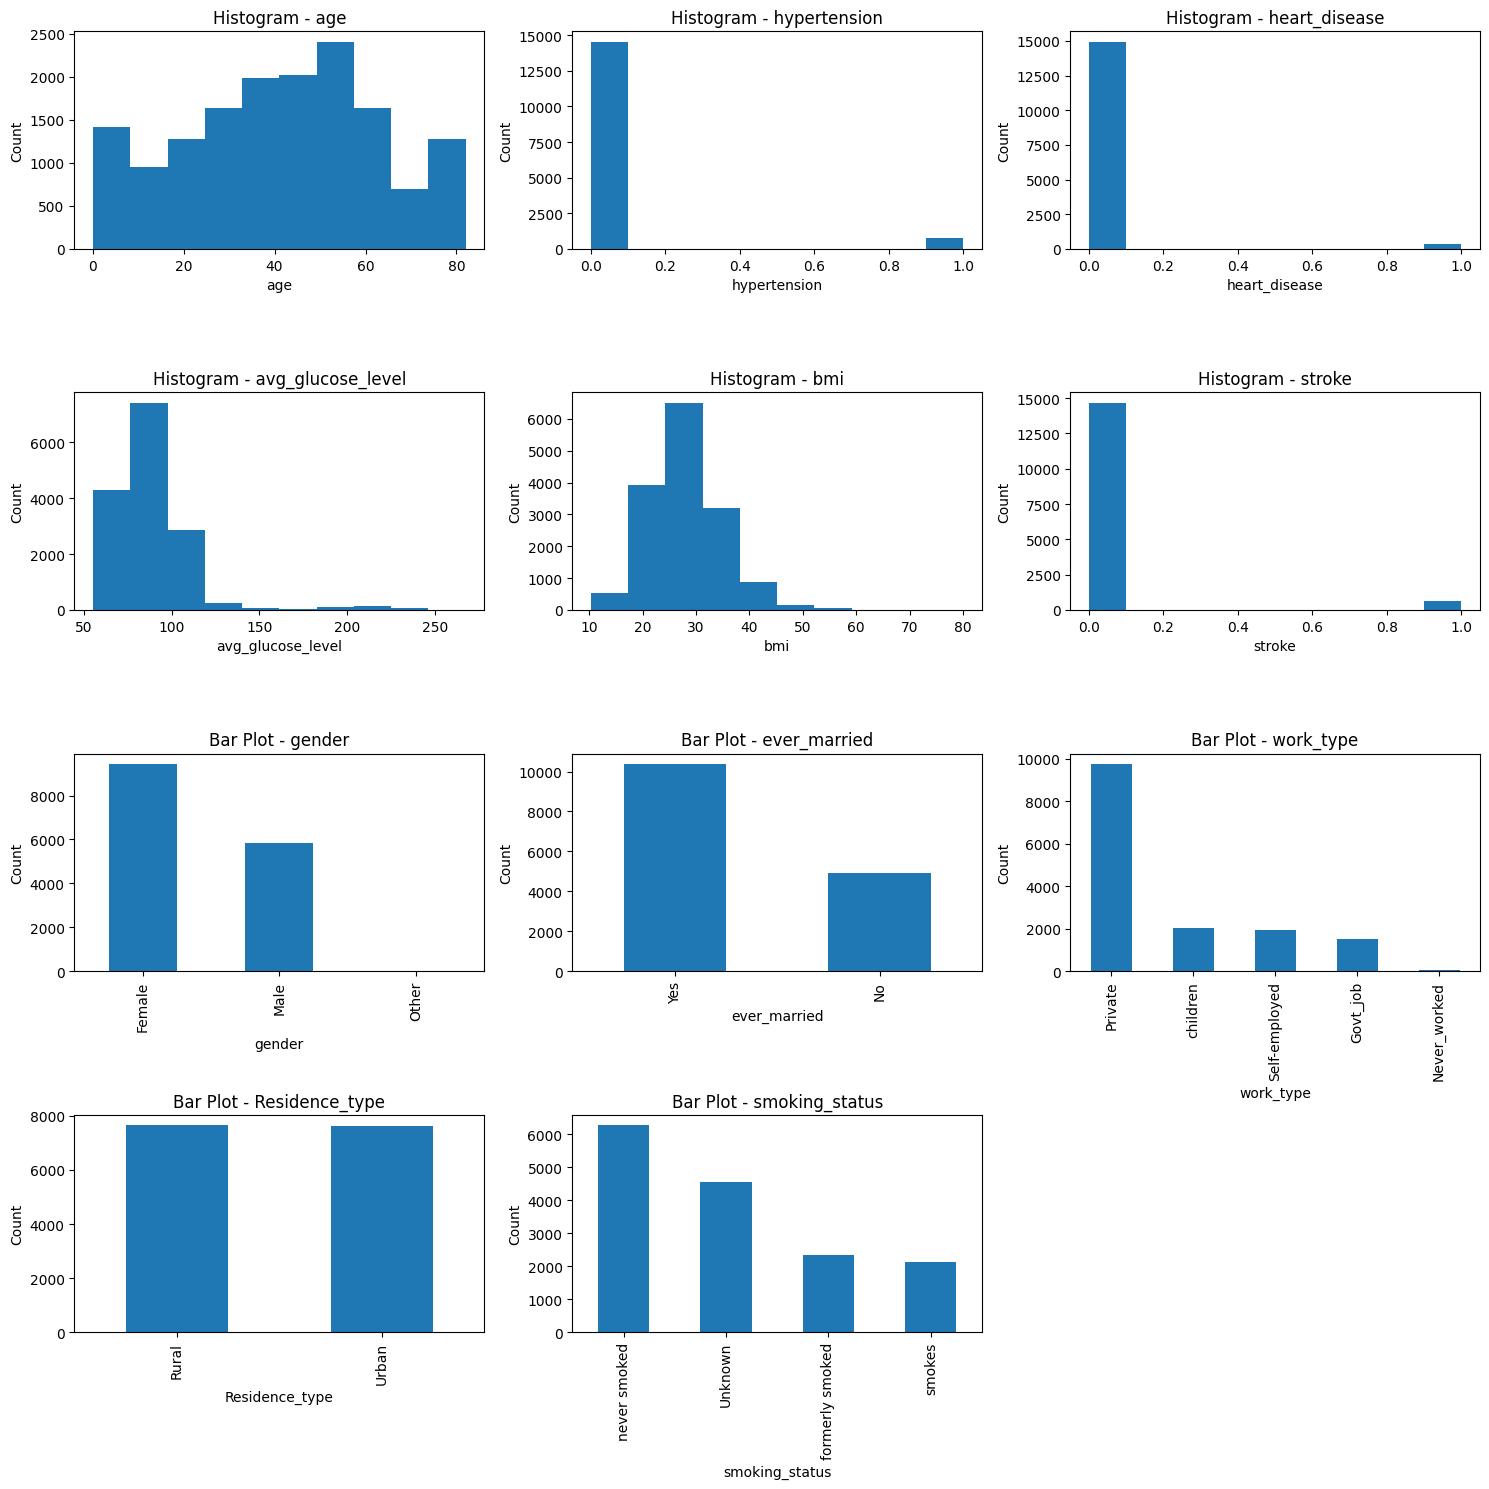

In [7]:
# 繪製特徵的分布
# 數值型欄位和物件型欄位分開畫
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
object_columns = train.select_dtypes(include='object').columns

# 根據train.info()，知道有11欄，因此決定畫成3x4的panel
num_rows = 4
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# 數值型畫histogram
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(train[column])
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_title(f'Histogram - {column}')

# 物件型畫bar plot
for i, column in enumerate(object_columns):
    row = (i + len(numeric_columns)) // num_cols
    col = (i + len(numeric_columns)) % num_cols
    train[column].value_counts().plot.bar(ax=axs[row, col])
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_title(f'Bar Plot - {column}')
    
# 刪除最後一個空圖
fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.show()

<ipython-input-8-7d5a7b96e55e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, fmt='.2f')


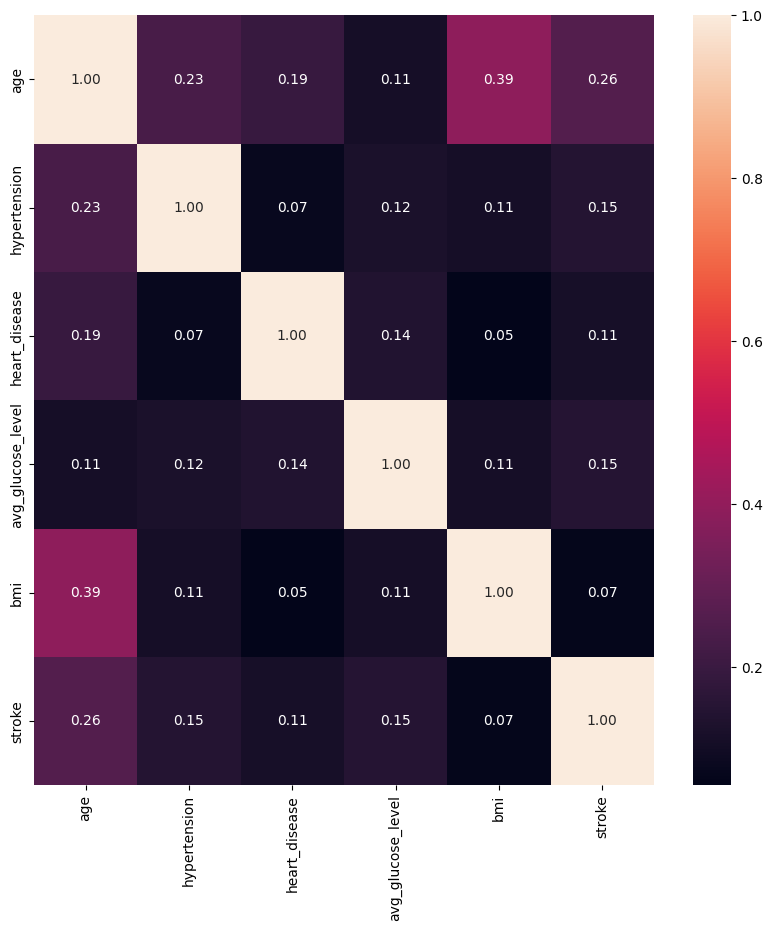

In [8]:
# 繪製相關熱圖
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, fmt='.2f')
plt.show()

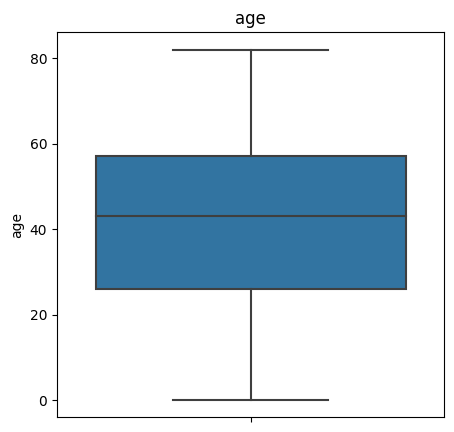

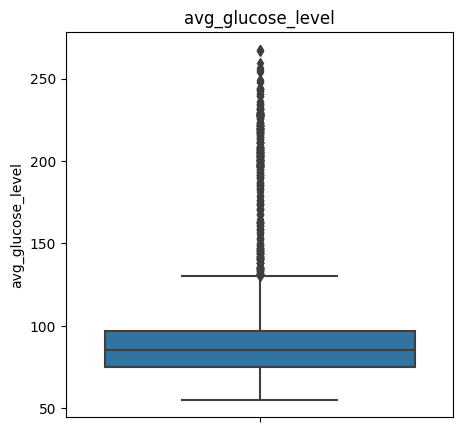

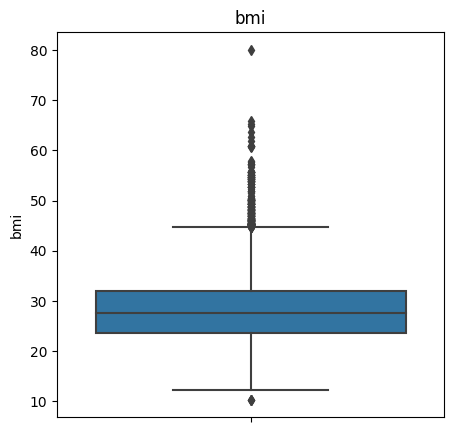

In [9]:
# 繪製箱型圖查看每個特徵的分布和異常值
for column in train.columns:
    if train[column].dtype in ['float64']:
        plt.figure(figsize=(5,5))
        sns.boxplot(y=train[column])
        plt.title(column)
        plt.show()

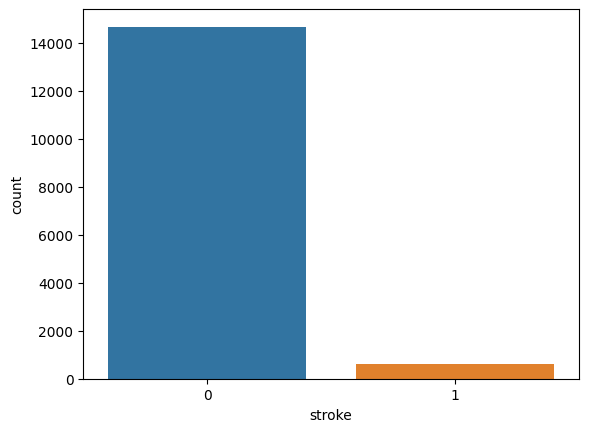

In [10]:
# 繪製目標變數的分布
sns.countplot(x='stroke', data=train)
plt.show()
# 發現有imbalance data問題，後續會處理

# 分割train set and test set

In [11]:
# 設定隨機種子
np.random.seed(1)

# 使用選擇到的特徵
X = train.drop(columns=['stroke'])
y = train['stroke']

# 分割資料集, 使用stratify sampling來維持training set and test set的y比例
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# 去除異常值

In [12]:
def outlier_to_remove(X_train, y_train, columns, method="zscore", threshold=3.0, target="all"):
    """
    :param X_train: (pandas.DataFrame) 要去除異常值的資料的X
    :param y_train: (pandas.Series) 要去除異常值的資料的y
    :param columns: (list) 需要去除異常值的列
    :param method: (string) 去除異常值的方法
                            zscore: z-score method
                            iqr: IQR method
    :param threshold: (float) z-score method的閾值
    :param target: (string) 針對df中的哪部分去除異常值
                            negative: 針對df.stroke == 0的列刪除異常值
                            positive: 針對df.stroke == 1的列刪除異常值
                            all: 針對全部的列刪除異常值
    :return: (pandas.DataFrame) 去除異常值並將任何含有異常值的行刪除
    """
    clean_data_X = X_train.copy()
    clean_data_y = y_train.copy()
    clean_data_y = pd.DataFrame(clean_data_y, columns=["stroke"])
    clean_data = pd.concat([clean_data_X, clean_data_y], axis=1)
    
    for col in columns:
        if method == "iqr":
            Q1 = clean_data_X[col].quantile(0.25)
            Q3 = clean_data_X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR
            outliers = (clean_data[col] < lower_limit) | (clean_data[col] > upper_limit)
        elif method == "zscore":
            z_scores = (clean_data[col] - clean_data[col].mean()) / clean_data[col].std()
            outliers = abs(z_scores) > threshold
        
        if target == "all":
            clean_data = clean_data.mask(outliers)
        elif target == "negative":
            clean_data = clean_data.mask(outliers & (clean_data.stroke == 0))
        elif target == "positive":
            clean_data = clean_data.mask(outliers & (clean_data.stroke == 1))
    return clean_data.dropna(how="any")

In [13]:
columns_to_clean = ["age", "avg_glucose_level", "bmi"]
clean_data = outlier_to_remove(X_train, y_train, columns_to_clean, 
                               method=OUTLIER_METHOD, threshold=OUTLIER_THRESHOLD, target=OUTLIER_TARGET)
clean_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
1039,Female,58.0,0.0,0.0,Yes,Private,Rural,127.21,21.8,Unknown,0.0
179,Female,26.0,0.0,0.0,No,Private,Rural,56.84,29.6,smokes,0.0
2010,Female,44.0,0.0,0.0,Yes,Govt_job,Rural,79.94,27.8,never smoked,0.0
6457,Female,43.0,0.0,0.0,Yes,Private,Rural,78.43,30.2,never smoked,0.0
11676,Male,52.0,0.0,0.0,Yes,Private,Urban,67.70,30.9,formerly smoked,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4540,Male,5.0,0.0,0.0,No,children,Urban,108.08,17.6,Unknown,0.0
15101,Female,60.0,1.0,0.0,Yes,Self-employed,Urban,95.36,21.5,smokes,0.0
11405,Female,35.0,0.0,0.0,Yes,Private,Urban,72.76,24.0,smokes,0.0


In [14]:
ratio = train.stroke.sum() / train.stroke.count()
ratio_clean = clean_data.stroke.sum() / clean_data.stroke.count()
print(f"Train            : Stoke-{y_train.sum()}, Ratio-{round(ratio*100, 2)}%")
print(f"Train after clean: Stoke-{int(clean_data.stroke.sum())}, Ratio-{round(ratio_clean*100, 2)}%")

Train            : Stoke-569, Ratio-4.13%
Train after clean: Stoke-569, Ratio-4.31%


In [15]:
X_train, y_train = clean_data.iloc[:,:-1], clean_data.stroke

# 針對數值資料做standardization and normalization

In [16]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = []
for variable in X_train.columns: #if column datatype = object, change it into dummy variable
    if X_train[variable].dtype == 'float64':
        columns_to_scale.append(variable)

#選擇需要標準化的欄位
X_train_scaled = X_train[columns_to_scale].copy()

#依據X_train的資料做標準化並轉換
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_scaled)

#創一個X_train_std，把轉換好的結果放進去取代未標準化的欄位
X_train_std = X_train.copy()
X_train_std[columns_to_scale] = scaled_data

#顯示標準化結果檢查一下
print('After stardardization of continuous columns in train set:')
display(X_train_std)
print()

#用相同的scaler來轉換test set (用.transform, 而不是.fit_transform)
X_test_scaled = X_test[columns_to_scale].copy()
scaled_data = scaler.transform(X_test_scaled)

#創一個X_test_std，把轉換好的結果放進去取代未標準化的欄位
X_test_std = X_test.copy()
X_test_std[columns_to_scale] = scaled_data

#顯示標準化結果檢查一下
print('After stardardization of continuous columns in test set:')
display(X_test)
display(X_test_std)
print()

#Note: 至此，我們的data有X_train_std, y_train; X_test_std, y_test

After stardardization of continuous columns in train set:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
1039,Female,0.785194,-0.222394,-0.145605,Yes,Private,Rural,2.230478,-0.958626,Unknown
179,Female,-0.700670,-0.222394,-0.145605,No,Private,Rural,-1.590121,0.312399,smokes
2010,Female,0.135128,-0.222394,-0.145605,Yes,Govt_job,Rural,-0.335953,0.019085,never smoked
6457,Female,0.088695,-0.222394,-0.145605,Yes,Private,Rural,-0.417935,0.410170,never smoked
11676,Male,0.506594,-0.222394,-0.145605,Yes,Private,Urban,-1.000499,0.524236,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
4540,Male,-1.675768,-0.222394,-0.145605,No,children,Urban,1.191853,-1.643024,Unknown
15101,Female,0.878060,4.496515,-0.145605,Yes,Self-employed,Urban,0.501245,-1.007512,smokes
11405,Female,-0.282771,-0.222394,-0.145605,Yes,Private,Urban,-0.725777,-0.600132,smokes



After stardardization of continuous columns in test set:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
10968,Male,46.00,1,0,Yes,Private,Urban,69.36,27.9,never smoked
13498,Male,15.00,0,0,No,Private,Rural,60.53,24.1,never smoked
2923,Female,49.00,0,0,Yes,Private,Urban,63.71,33.8,formerly smoked
7757,Male,1.88,0,0,No,children,Rural,69.25,16.8,Unknown
13205,Female,62.00,0,0,Yes,Private,Rural,92.99,33.3,never smoked
...,...,...,...,...,...,...,...,...,...,...
4890,Male,17.00,0,0,No,Private,Rural,79.61,24.5,smokes
4285,Female,75.00,1,0,Yes,Private,Urban,207.63,32.0,never smoked
4631,Male,51.00,1,0,Yes,Govt_job,Urban,86.30,30.5,formerly smoked


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
10968,Male,0.227995,4.496515,-0.145605,Yes,Private,Urban,-0.910373,0.035380,never smoked
13498,Male,-1.211436,-0.222394,-0.145605,No,Private,Rural,-1.389780,-0.583837,never smoked
2923,Female,0.367295,-0.222394,-0.145605,Yes,Private,Urban,-1.217128,0.996797,formerly smoked
7757,Male,-1.820640,-0.222394,-0.145605,No,children,Rural,-0.916345,-1.773385,Unknown
13205,Female,0.970927,-0.222394,-0.145605,Yes,Private,Rural,0.372571,0.915321,never smoked
...,...,...,...,...,...,...,...,...,...,...
4890,Male,-1.118569,-0.222394,-0.145605,No,Private,Rural,-0.353869,-0.518656,smokes
4285,Female,1.574559,4.496515,-0.145605,Yes,Private,Urban,6.596722,0.703483,never smoked
4631,Male,0.460161,4.496515,-0.145605,Yes,Govt_job,Urban,0.009351,0.459055,formerly smoked


# Encoder

In [19]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.6 MB/s eta 0:00:00


In [20]:
import category_encoders as ce

class Encoder:
    def __init__(self, X, y):
        self.X = X.copy()
        self.y = y
        self.df = pd.concat([self.X, self.y], axis=1)
        self.columns_to_encode = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        self.map = {}
        self.set_frequency_mapping()
        self.enc_target = ce.TargetEncoder(cols=self.columns_to_encode)
        self.enc_target.fit(self.df, self.df['stroke'])

#     def one_hot_encoding(self, df):
#         # One-hot encoding
#         df = df.copy()
#         return pd.get_dummies(df, columns=self.columns_to_encode, drop_first=True)
    
    def set_frequency_mapping(self):
        # 設立frequency encoding的mapping，以利於後續將類別資料轉換成出現頻率及逆轉換回類別資料
        self.frequency_X = self.X.copy()
        for variable in self.columns_to_encode:
            counts = self.frequency_X[variable].value_counts()
            self.map[variable] = counts.to_dict()
            self.frequency_X[variable] = self.frequency_X[variable].replace(counts)
    
    def frequency_encoding(self, df):
        # 將類別資料依照其出現頻率轉換
        df = df.copy()
        for variable in self.columns_to_encode:
            df[variable] = df[variable].replace(self.map[variable])
        return df
    
    def inverse_frequency_encoding(self, df):
        # 將出現頻率逆轉換回類別資料
        df = df.copy()
        for variable in self.columns_to_encode:
            df[variable] = df[variable].replace({v: k for k, v in self.map[variable].items()})
        return df
    
    def target_encoding(self, X, y):
        # Target encoding
        df = pd.concat([X, y], axis=1)
        df_encoded = self.enc_target.transform(df)
        return df_encoded.drop(columns=["stroke"])

In [21]:
enc = Encoder(X_train_std, y_train)
# target encoding
X_train_enc = enc.target_encoding(X_train_std, y_train)
X_test_enc = enc.target_encoding(X_test_std, y_test)

# # frequency encoding
# X_train_enc = enc.frequency_encoding(X_train_std)
# X_test_enc = enc.frequency_encoding(X_test_std)

display(X_train_enc.head())
display(X_test_enc.head())
# Note: 目前我們的data為X_train_enc, y_train; X_test_enc, y_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
1039,0.040724,0.785194,0.035862,0.039384,0.059572,0.044128,0.043544,2.230478,-0.958626,0.024048
179,0.040724,-0.700670,0.035862,0.039384,0.009264,0.044128,0.043544,-1.590121,0.312399,0.052135
2010,0.040724,0.135128,0.035862,0.039384,0.059572,0.047619,0.043544,-0.335953,0.019085,0.042910
6457,0.040724,0.088695,0.035862,0.039384,0.059572,0.044128,0.043544,-0.417935,0.410170,0.042910
11676,0.047012,0.506594,0.035862,0.039384,0.059572,0.044128,0.042685,-1.000499,0.524236,0.073999


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
10968,0.047012,0.227995,0.189711,0.039384,0.059572,0.044128,0.042685,-0.910373,0.035380,0.042910
13498,0.047012,-1.211436,0.035862,0.039384,0.009264,0.044128,0.043544,-1.389780,-0.583837,0.042910
2923,0.040724,0.367295,0.035862,0.039384,0.059572,0.044128,0.042685,-1.217128,0.996797,0.073999
7757,0.047012,-1.820640,0.035862,0.039384,0.009264,0.000548,0.043544,-0.916345,-1.773385,0.024048
13205,0.040724,0.970927,0.035862,0.039384,0.059572,0.044128,0.043544,0.372571,0.915321,0.042910


# 處理不平衡資料 (imbalance data)

In [22]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from imblearn.over_sampling import SMOTE

def balance(X_train, y_train, method="downsampled"):
    df = pd.concat([X_train, y_train], axis=1)
    # 分開兩種類別
    stroke_positive = df[df['stroke'] == 1]
    stroke_negative = df[df['stroke'] == 0]

    if method == "downsampled":
        # 下採樣
        stroke_negative_downsampled = stroke_negative.sample(n=len(stroke_positive), replace=False, random_state=1)
        # 重新組合數據
        df_balanced = pd.concat([stroke_positive, stroke_negative_downsampled])
    elif method == "smote":
        smote = SMOTE(sampling_strategy=1) # 合成新資料，使比例為 1 : 1
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        df_balanced = pd.concat([X_train_resampled, y_train_resampled], axis=1)
    
    return df_balanced.drop(columns=["stroke"]), df_balanced["stroke"]

Original Data


0.0    12629
1.0      569
Name: stroke, dtype: int64

Resampled Data


1.0    569
0.0    569
Name: stroke, dtype: int64

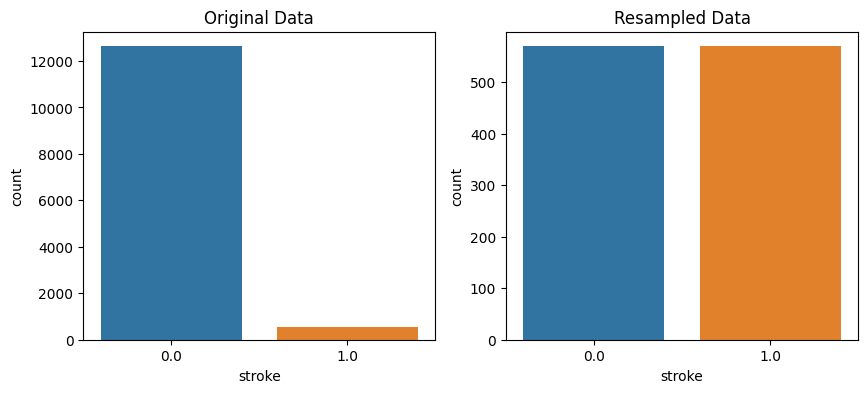

In [24]:
# 比較處理前後的data, 繪製目標變數的分布：顯示數字
X_train_resampled, y_train_resampled = balance(X_train_enc, y_train, method=BALANCE)

print('Original Data')
display(y_train.value_counts())
print('Resampled Data')
display(y_train_resampled.value_counts())

# 以bar plot顯示
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# 原始數據bar plot
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Original Data')
# resampling後的bar plot
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title('Resampled Data')

plt.show()

#Note: 目前我們的data為X_train_resampled, y_train_resampled; X_test_enc, y_test

In [25]:
X_train_resampled.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
count,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000
mean,0.043216,0.607599,0.054654,0.050116,0.049183,0.047827,0.043099,0.529840,0.206294,0.046019
std,0.003077,1.038195,0.050400,0.042588,0.020374,0.019951,0.000430,2.112632,0.967956,0.016745
min,0.040724,-1.904220,0.035862,0.039384,0.009264,0.000548,0.042685,-1.668846,-2.376307,0.024048
25%,0.040724,-0.004171,0.035862,0.039384,0.059572,0.044128,0.042685,-0.556654,-0.420885,0.042910
50%,0.040724,0.738761,0.035862,0.039384,0.059572,0.044128,0.042685,-0.004222,0.133152,0.042910
75%,0.047012,1.516518,0.035862,0.039384,0.059572,0.047619,0.043544,0.704301,0.752369,0.052135
max,0.047012,1.899592,0.189711,0.218978,0.059572,0.082126,0.043544,9.852674,5.412792,0.073999


# 特徵選取 (Feature selection)

age                  0.424431
avg_glucose_level    0.200809
bmi                  0.155981
smoking_status       0.047891
work_type            0.044607
ever_married         0.042270
hypertension         0.027330
gender               0.021294
Residence_type       0.020033
heart_disease        0.015352
dtype: float64



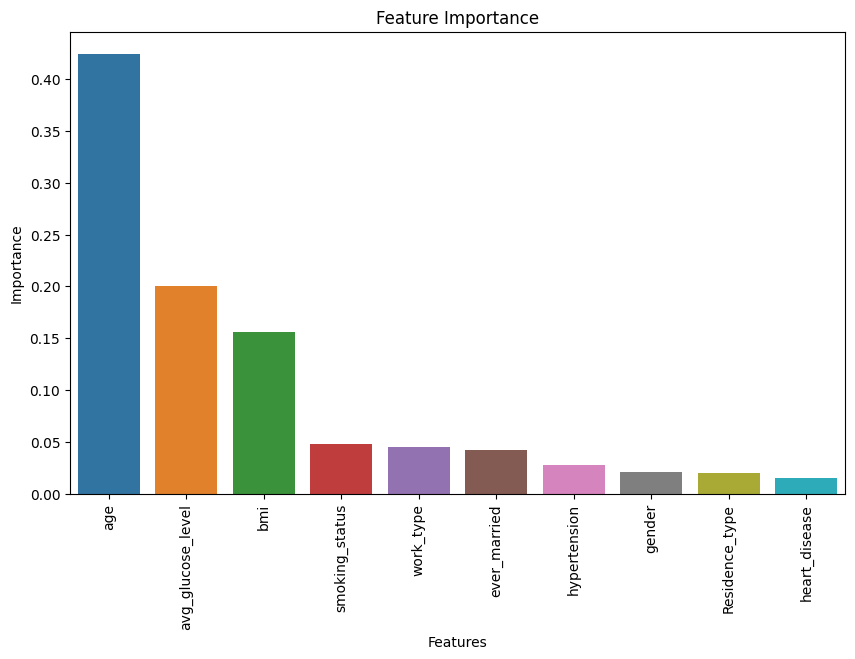

Selected features: {'avg_glucose_level', 'heart_disease', 'hypertension', 'smoking_status', 'bmi', 'gender', 'age'}


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 創建一個隨機森林分類器
rf = RandomForestClassifier(n_estimators=1000)

# 用特徵與目標變數來訓練模型
rf.fit(X_train_resampled, y_train_resampled)

# 計算每個特徵的重要性，並轉換為Series以方便後續操作
importances = pd.Series(rf.feature_importances_, index=X_train_resampled.columns)

# 打印出每個特徵的重要性
importances_sorted = importances.sort_values(ascending=False)
print(importances_sorted)
print()

# 使用Seaborn的barplot畫出importance barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.index, y=importances_sorted.values)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# 利用SelectFromModel來自動選擇重要特徵
selector = SelectFromModel(rf, prefit=True)

# 獲得被選擇的特徵的索引
selected_features_idx = selector.get_support()

# 轉換為特徵名稱
selected_features = X_train_resampled.columns[selected_features_idx].tolist()

# 由於經文獻探討，gender、age、hypertension、heart disease、avg_glucose_level、smoking_status、bmi皆為stroke risk factor，將其加入Selected features
# Ref: https://www.nhlbi.nih.gov/health/stroke/causes
risk_factor = {"gender", "age", "hypertension", "heart_disease", "avg_glucose_level", "smoking_status", "bmi"}
selected_features = set(selected_features) | risk_factor

print(f"Selected features: {selected_features}")

# 訓練模型 (Train)

Training Logistic Regression...
Test accuracy: 0.7675438596491229
ROC AUC: 0.8650353955063097

Test accuracy: 0.7763157894736842
ROC AUC: 0.8695752539242845

Test accuracy: 0.8026315789473685
ROC AUC: 0.9038935056940597

Test accuracy: 0.801762114537445
ROC AUC: 0.8941934482223257

Test accuracy: 0.788546255506608
ROC AUC: 0.876649588573203

Training Random Forest...
Test accuracy: 0.7807017543859649
ROC AUC: 0.8682671591258849

Test accuracy: 0.7982456140350878
ROC AUC: 0.8941597414589105

Test accuracy: 0.8070175438596491
ROC AUC: 0.8946598953524161

Test accuracy: 0.788546255506608
ROC AUC: 0.8889535786368576

Test accuracy: 0.8105726872246696
ROC AUC: 0.8983465300419189

Training Gradient Boosting...
Test accuracy: 0.7675438596491229
ROC AUC: 0.8784626038781163

Test accuracy: 0.7807017543859649
ROC AUC: 0.8755771006463527

Test accuracy: 0.7894736842105263
ROC AUC: 0.8950061557402278

Test accuracy: 0.7797356828193832
ROC AUC: 0.8771153547585778

Test accuracy: 0.788546255506608
R

,best_model,accuracy,roc_auc
Logistic Regression,LogisticRegression(),0.802632,0.903894
Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.810573,0.898347
Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.789474,0.895006
K Nearest Neighbor,KNeighborsClassifier(),0.824561,0.868729


---------------------------
Best model:  Logistic Regression
highest auc:  0.9038935056940597


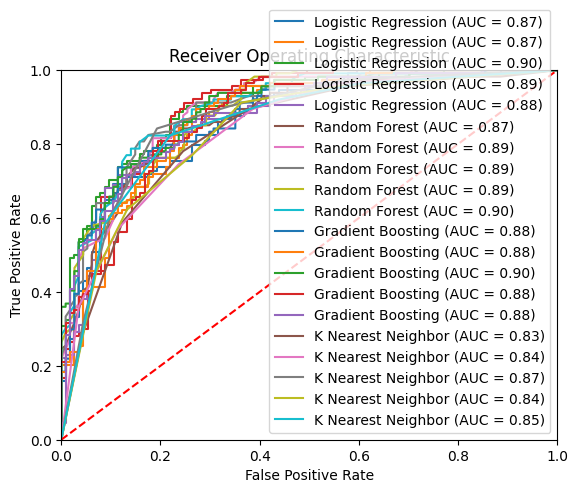

In [27]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np

# 設定隨機種子
np.random.seed(1)

# 使用選擇到的特徵
features = selected_features
X_train = X_train_resampled[list(features)]
y_train = y_train_resampled
X_test = X_test_enc[list(features)]
y_test = y_test

# 定義模型
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('K Nearest Neighbor', KNeighborsClassifier())
]


def fold_method(method="KFold", n_split=5):
    if method == "KFold":
        # KFold交叉驗證
        return KFold(n_splits=5)
    elif method == "StratifiedKFold":
        # 使用stratified kfold, 才不會在roc時遇到y只有一個類別的問題
        return StratifiedKFold(n_splits=5)
    
kfold = fold_method(method=FOLD_METHOD, n_split=FOLD_N_SPLIT)

    
# 創一個空的dataframe
# 用來儲存每個模型中最好的模型（依據roc_auc判斷），及其準確度(accurary)
model_summary = pd.DataFrame(columns=["best_model",
                                      "accuracy",
                                      "roc_auc"])
for name, model in models:
    model_summary = pd.concat([model_summary,
                               pd.DataFrame({"best_model":None,
                                             "accuracy":None,
                                             "roc_auc":0}, index=[name])])
# best_model = None
# highest_accuracy = 0
# highest_auc = 0


for name, model in models:
    print(f"Training {name}...")
    for train_index, valid_index in kfold.split(X_train, y_train):
        # 分割訓練集與驗證集
        KX_train, KX_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
        Ky_train, Ky_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        # 使用整個訓練集重新訓練模型
        model.fit(KX_train, Ky_train)

        # 計算驗證集的準確度
        y_pred = model.predict(KX_valid)
        y_proba = model.predict_proba(KX_valid)[:, 1]
        accuracy = accuracy_score(Ky_valid, y_pred)
        
        fpr, tpr, thresholds = roc_curve(Ky_valid, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        print(f"Test accuracy: {accuracy}")
        print(f"ROC AUC: {roc_auc}\n")

        # 如果這個模型的roc_auc比先前的模型更好，則儲存這個模型
        if roc_auc > model_summary.loc[name,"roc_auc"]:
            model_summary.at[name,"best_model"] = model
            model_summary.loc[name,"roc_auc"] = roc_auc
            model_summary.loc[name,"accuracy"] = accuracy
#             best_model_name = name
#             best_model = model
#             highest_auc = roc_auc
display(model_summary)
model_summary["roc_auc"] = pd.to_numeric(model_summary["roc_auc"])
best_model_name = model_summary["roc_auc"].idxmax()
best_model = model_summary.loc[best_model_name,"best_model"]
highest_auc = model_summary.loc[best_model_name,"roc_auc"]
print('---------------------------')
print("Best model: ",best_model_name)
print("highest auc: ",highest_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# 測試資料 (AUROC on testing dataset)

## All models

Testing Logistic Regression...
Testing Random Forest...
Testing Gradient Boosting...
Testing K Nearest Neighbor...


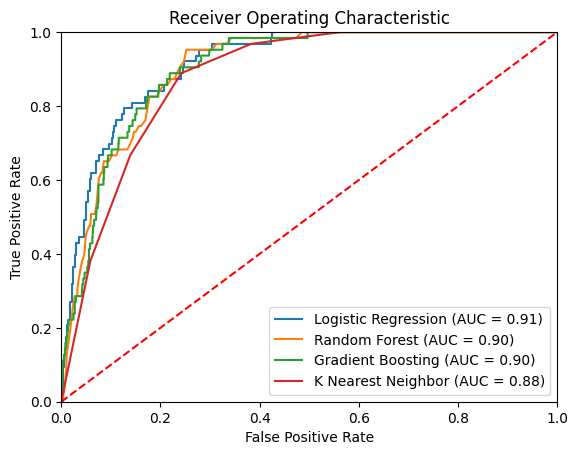

In [28]:
for name, model in models:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    print(f"Testing {name}...")
    
#     for train_index, valid_index in kfold.split(X_train, y_train):
#         # 分割訓練集與驗證集
#         KX_train, KX_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
#         Ky_train, Ky_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

#         # 訓練模型
#         model.fit(KX_train, Ky_train)


    # 預測測試集的結果並計算ROC AUC
    y_proba = model_summary.loc[name,"best_model"].predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Best model

Best model AUROC: 0.9140283724752389


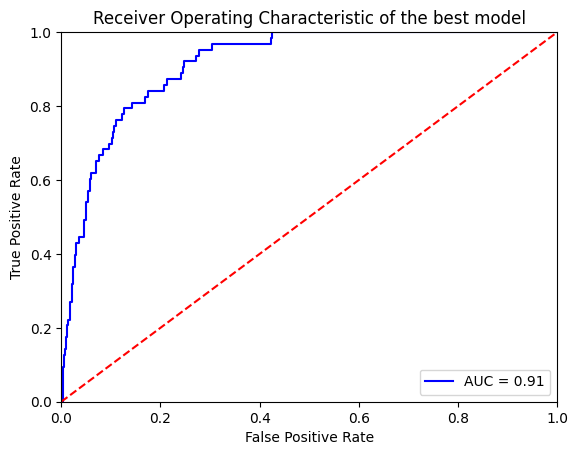

In [29]:
# 使用最佳模型預測測試集
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# 計算 ROC curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)

# 計算 AUROC
roc_auc_best = auc(fpr_best, tpr_best)

print(f"Best model AUROC: {roc_auc_best}")

# 繪製 ROC curve
plt.title('Receiver Operating Characteristic of the best model')
plt.plot(fpr_best, tpr_best, 'b', label = f'AUC = {roc_auc_best:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 上傳Kaggle Competition (Kaggle Test Data)

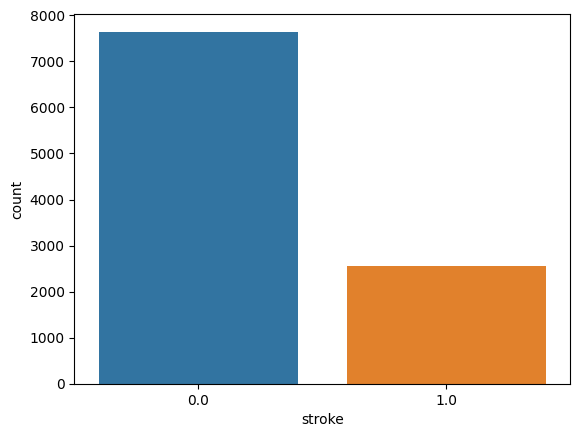

In [30]:
# 注意到你的測試集可能不包含所有的類別變數，這裡我們需要保證測試集和訓練集有相同的columns
missing_cols = set(X_train.columns) - set(test.columns)
test.drop(missing_cols, axis=1)

# 利用先前train的參數來標轉化
test_scaled = test[columns_to_scale].copy()
test_scaled_data = scaler.transform(test_scaled)
test_std = test.copy()
test_std[columns_to_scale] = test_scaled_data

# 由於target encoding需輸入y，先模擬一個空值的y(不影響結果)
nan_array = np.full((len(test_std), 1), np.nan)
y = pd.DataFrame(nan_array, columns=["stroke"], index=test_std.index)
# 與先前用相同encoding方式
test_enc = enc.target_encoding(test_std, y) # target encoding
# test_enc = enc.frequency_encoding(test_std) # frequency encoding


# 保證測試集的columns順序和訓練集相同
test_enc = test_enc[X_train.columns]

# 使用訓練集中選擇的特徵
test_enc = test_enc[list(features)]

# 用模型來預測測試集
test_preds = best_model.predict(test_enc)

# 建立submission DataFrame
submission = pd.DataFrame({'id': test.index, 'stroke': test_preds})

# Overview一下submission data
sns.countplot(x='stroke', data=submission)

# 輸出到CSV文件
submission.to_csv('submission.csv', index=False)

# 分工說明

In [31]:
# 工作流程
#### * 撰寫程式碼
#### * 選擇程式碼模板
#### * 討論並確認分析流程
#### * 整合所有程式碼
#### *檢查並修改整合後程式碼

# 分工
## * 吳松濤
#### ** 撰寫程式碼 (all)
#### ** 寫出程式碼架構
#### ** 討論並確認分析流程
#### ** 檢查並修改整合後程式碼

## * 蕭承瀚
#### ** 撰寫程式碼 (encoding, model training, testing)
#### ** 討論並確認分析流程
#### ** 整合所有程式碼

## * 袁章祖
#### ** 撰寫程式碼(data cleaning)
#### ** 討論並確認分析流程
#### ** 檢查並修改整合後程式碼
